In [ ]:
import os, glob
ROOT = "/kaggle/input/oct2017"   # expected mount point on Kaggle
# if that path doesn't exist, list /kaggle/input to find the exact folder
if not os.path.exists(ROOT):
    print("Expected /kaggle/input/oct2017 not found. Listing /kaggle/input:")
    print(os.listdir("/kaggle/input"))
else:
    print("Found:", ROOT)
    # try common nested folder name
    candidates = [ROOT, os.path.join(ROOT,"OCT2017"), os.path.join(ROOT,"oct2017"), os.path.join(ROOT,"OCT2017/")]
    for c in candidates:
        if os.path.exists(c):
            print("Using dataset root:", c)
            ROOT = c
            break
    # show top-level
    for split in ["train","val","test"]:
        p = os.path.join(ROOT, split)
        if os.path.exists(p):
            classes = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p,d))]
            print(f"{split}/ found with classes: {classes}  | counts:")
            for cls in classes:
                n = len(glob.glob(os.path.join(p,cls,"*")))
                print(f"  {cls}: {n}")
        else:
            print(f"{split}/ not found at {p}")


In [1]:
# MODEL & TRAINING UTILITIES (define only; do NOT start training yet)
import os, time, random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


2025-10-26 01:16:19.626864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761441379.873191      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761441379.935425      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATA_DIR = "/kaggle/input/oct2017/train"   # original train (or your working copy)
VAL_DIR  = "/kaggle/input/oct2017/val"
IMG_SIZE = 224
NUM_CLASSES = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# !pip install -q albumentations


In [ ]:
#import albumentations as A


In [ ]:
#from albumentations.pytorch import ToTensorV2



In [4]:
# === get_dataloaders() using Albumentations (final tested) ===
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random, torch

def get_dataloaders(train_dir, val_dir, img_size=224, batch_size=32, subset_per_class=None, num_workers=2):
    train_tf = A.Compose([
        A.RandomResizedCrop(size=(img_size, img_size), scale=(0.8, 1.0), ratio=(0.9,1.1)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.4),
        A.Affine(translate_percent=0.02, scale=(0.95,1.05), rotate=(-10,10), p=0.5),
        A.CLAHE(p=0.2),
        A.MotionBlur(blur_limit=3, p=0.2),
        A.Normalize(mean=(0.485,0.485,0.485), std=(0.229,0.229,0.229)),
        ToTensorV2()
    ])
    val_tf = A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=(0.485,0.485,0.485), std=(0.229,0.229,0.229)),
        ToTensorV2()
    ])

    class AlbumentationsDataset(torch.utils.data.Dataset):
        def __init__(self, folder, transform=None):
            self.ds = datasets.ImageFolder(folder)
            self.transform = transform
        def __getitem__(self, idx):
            path, label = self.ds.samples[idx]
            img = np.array(Image.open(path).convert("RGB"))
            if self.transform:
                img = self.transform(image=img)["image"]
            return img, label
        def __len__(self):
            return len(self.ds)
        @property
        def classes(self):
            return self.ds.classes

    train_ds = AlbumentationsDataset(train_dir, transform=train_tf)
    val_ds = AlbumentationsDataset(val_dir, transform=val_tf)

    # optional balanced subset per class
    if subset_per_class is not None:
        indices = []
        cls_to_indices = {}
        for idx, (_,label) in enumerate(train_ds.ds.samples):
            cls_to_indices.setdefault(label, []).append(idx)
        for cls, idxs in cls_to_indices.items():
            take = min(subset_per_class, len(idxs))
            indices += random.sample(idxs, take)
        train_ds = Subset(train_ds, indices)

    # dataloaders (shuffle True for train)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # classes lookup works even if train_ds is Subset
    classes = train_ds.dataset.classes if isinstance(train_ds, Subset) else train_ds.classes
    return train_loader, val_loader, classes


In [5]:
# 2) Model factory
def create_model(model_name='efficientnet_b0', num_classes=NUM_CLASSES, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model.to(DEVICE)

In [6]:
# 3) Training and validation routines
def train_epoch(model, dataloader, criterion, optimizer, device=DEVICE):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def validate(model, dataloader, criterion, device=DEVICE):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total if total>0 else 0.0
    acc = correct / total if total>0 else 0.0
    return avg_loss, acc

In [7]:
# 4) Check: instantiate small objects (no training)
print("Device:", DEVICE)
print("Model factory and dataloader functions defined.")


Device: cuda
Model factory and dataloader functions defined.


In [8]:
import time, numpy as np
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import os, torch

In [9]:
# CONFIG
MODEL_NAME = "efficientnet_b0"
SUBSET_PER_CLASS = 500      # use balanced subset for quick/robust runs; set None to use full
BATCH_SIZE = 16
LR = 3e-4
NUM_EPOCHS = 20
PATIENCE = 4
CKPT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
CKPT_PATH = os.path.join(CKPT_DIR, f"best_{MODEL_NAME}.pt")

In [10]:
train_loader, val_loader, classes = get_dataloaders(train_dir=DATA_DIR, val_dir=VAL_DIR,
                                                    img_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                    subset_per_class=SUBSET_PER_CLASS, num_workers=4)


In [11]:
print("Classes:", classes)
print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train batches: 125 Val batches: 1054


In [12]:
model = create_model(model_name=MODEL_NAME, num_classes=len(classes), pretrained=True)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)   # requires torch >= 1.10
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=max(1, NUM_EPOCHS))

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [13]:
best_val = 0.0
no_improve = 0

In [14]:
for epoch in range(1, NUM_EPOCHS+1):
    t0 = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device=DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, device=DEVICE)
    scheduler.step()

    print(f"Epoch {epoch}/{NUM_EPOCHS} — train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f} — time: {time.time()-t0:.1f}s")

    # Save best model
    if val_acc > best_val + 1e-4:
        best_val = val_acc
        no_improve = 0
        torch.save({'model_state_dict': model.state_dict(), 'classes': classes}, CKPT_PATH)
        print("  -> Saved new best model:", CKPT_PATH)
    else:
        no_improve += 1
        print(f"  -> no improvement ({no_improve}/{PATIENCE})")

    if no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Training finished. Best val_acc:", best_val)


Epoch 1/20 — train_loss: 1.5502, train_acc: 0.6630 | val_loss: 1.2282, val_acc: 0.6993 — time: 56.1s
  -> Saved new best model: /kaggle/working/checkpoints/best_efficientnet_b0.pt
Epoch 2/20 — train_loss: 0.8369, train_acc: 0.8010 | val_loss: 0.7604, val_acc: 0.8300 — time: 45.8s
  -> Saved new best model: /kaggle/working/checkpoints/best_efficientnet_b0.pt
Epoch 3/20 — train_loss: 0.6202, train_acc: 0.8425 | val_loss: 0.8716, val_acc: 0.7831 — time: 45.9s
  -> no improvement (1/4)
Epoch 4/20 — train_loss: 0.5157, train_acc: 0.8885 | val_loss: 0.5079, val_acc: 0.8855 — time: 46.0s
  -> Saved new best model: /kaggle/working/checkpoints/best_efficientnet_b0.pt
Epoch 5/20 — train_loss: 0.4324, train_acc: 0.9180 | val_loss: 0.5013, val_acc: 0.8939 — time: 46.5s
  -> Saved new best model: /kaggle/working/checkpoints/best_efficientnet_b0.pt
Epoch 6/20 — train_loss: 0.3898, train_acc: 0.9300 | val_loss: 0.4936, val_acc: 0.8933 — time: 46.6s
  -> no improvement (1/4)
Epoch 7/20 — train_loss: 0

In [15]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [30]:
IMG_PATH = "/kaggle/input/oct2017/val/DRUSEN/DRUSEN-1020679-3.jpeg"  # <- replace with your image path


In [31]:
#model.eval()


🧠 Predicted Disease: DRUSEN (Confidence: 92.16%)


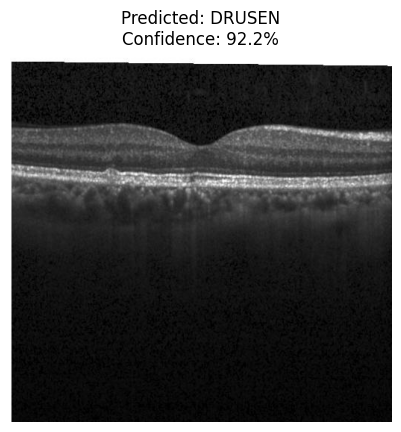

In [32]:
# Same preprocessing as validation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                         std=[0.229, 0.229, 0.229])
])

# Load & preprocess image
img = Image.open(IMG_PATH).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(DEVICE)

# Inference
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    conf, pred = torch.max(probs, 1)
    pred_class = classes[pred.item()]
    conf_value = conf.item()

print(f"🧠 Predicted Disease: {pred_class} (Confidence: {conf_value*100:.2f}%)")

# Show image
plt.imshow(np.array(img))
plt.title(f"Predicted: {pred_class}\nConfidence: {conf_value*100:.1f}%")
plt.axis("off")
plt.show()

In [19]:
import torch

# Save the model weights
torch.save(model.state_dict(), "genaiversityB0New.pth")
